#Fianl Report - Introduction to Deep Learning
Dor Shmuel 312179971 
 
Moshe Davidian 201402856


# Lung Damages X-Ray Classifier Project -1st stage

#Introduction

##Background
The lungs are the primary organs of the respiratory system in humans and other animals. In humans, the main muscle of respiration that drives breathing is the diaphragm. The lungs also provide airflow that makes vocal sounds including human speech possible.
There are some diseases that can happen in the lungs. One of them is COVID-19, a disease that has entered to our life recently. Coronavirus disease 2019 (COVID-19) is a contagious disease caused by severe acute respiratory syndrome. The first known case was identified in Wuhan, China in December 2019. The disease has since spread worldwide and leading to an ongoing pandemic. 

Symptoms of **COVID-19** are variable, but often includes fever, cough, headache, fatigue, breathing difficulties and loss of smell and taste. Of those people who develop noticeable symptoms enough to be classed as patients, most (81%) develop mild to moderate symptoms (up to mild pneumonia), while 14% develop severe symptoms (dyspnea, hypoxia, or more than 50% lung involvement on imaging), and 5% suffer critical symptoms (respiratory failure, shock or multiorgan dysfunction). Older people are at a higher risk of developing severe symptoms. 

Another disease that can influence the lungs is **Viral Pneumonia**.
Viral pneumonia is a pneumonia caused by a virus. Pneumonia is an infection that causes inflammation in one or both lungs. The pulmonary alveoli fill with fluid or pus making it difficult to breathe. Pneumonia can be caused by bacteria, viruses, fungi or parasites. The Symptoms of viral pneumonia include fever, non-productive cough, runny nose and systemic symptoms (for example: myalgia, headache). There are several ways for a diagnosis to be obtained, which one of them is by ordering a chest X-Ray. 

The last disease we will deal with is **Lung Opacity**. Also called Ground-glass opacity (GGO). It is a finding seen on chest x-ray (radiograph) or computed tomography (CT) imaging of the lungs. It is typically defined as an area of hazy opacification or increased attenuation due to air displacement by fluid, airway collapse, fibrosis, or a neoplastic process. When a substance other than air fills an area of the lung it increases that area's density. 
In both CT and chest radiographs, **Normal** lungs appear dark due to the relative lower density of air compared to the surrounding tissues. When air is replaced by another substance (e.g fluid or fibrosis), the density of the area increases, causing the tissue to appear lighter or greyer.





##The problem
As part of the diagnosis of various lung diseases, such as those described above, experts use X-ray imaging technology to identify and monitor the patient's lungs, and from this they conclude what type of disease the patient suffers from.

This inference process requires a great deal of knowledge and expertise, many resources and valuable time which is often required in order to give the appropriate treatment as soon as possible in order to save the patient's life.

The Covid-19 epidemic that broke out in the past year has brought with it many challenges, with the most prominent challenge being to perform efficient, rapid and accurate identification in favor of isolating the patient and providing an appropriate response. At the same time, Covid-19 disease is characterized by many symptoms that are so indistinguishable from various lung diseases such as viral pneumonia, lungs opacity, and so on. As a result, content experts in this world are required to gather a great deal of information and conduct research in order to reliably monitor the type of disease based on an X-ray of the lungs.


##The Project 
In this project we will develop and design deep neural network that will receive an X-ray of a person's lung, and will exhibit a classification task in order to correctly  identify if the patient is suffering from a lungs diseases or the patient is healthy and classified as a normal condition.

In the **First stage**, we will build a classifier that will decide whether the lungs have been affected by the corona virus or not.

In the **Second stage**, we will upgrade the network, and now it will be capable to differentiate between different lungs damage.
This classification will be based only on data and computer vision algorithms in order to redundant the usage of experts, to preform accurate and rapid identification.  


### 1. import Libraries

In [ ]:
import time
import copy
import torch
import torchvision
from torchvision import models
from torchsummary import summary
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os.path
import os as path

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi
device
drive.mount('/content/gdrive')

#Data
COVID-19 Radiography Database - COVID-19 Chest X-ray Database
taken from :[covid19-radiography-database](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)

Our data is divided into 4 Classes:
1.	Normal: 10192 images 
2.	Covid:3616 images
3.	Viral Pneumonia: 1345 images (will be used only in the 2nd Stage)
4.	Lung Opacity: 6012 images (will be used only in the 2nd Stage)

Where our training data is comprised of 70% of the data, the validation comprised of 10% of the data and the test is comprised of 20% of the data.


##Pre-Processing

Pre-Processing of the images (most based on the article in (Vu, 2021)):

a.	Resize: size = (3,224,224)

b.	Convert to Tensor.

c.	Normalize the images with mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225])

d.	Conversion to DataLoader type. 


### 2. Data Arrngment

**In the first time (only):**

Change to **Arrange=True**

Change to **root_dir=**'the data path' 

in this path, the data should be in "/Data/COVID-19_Radiography_Dataset"

i.e. "My_path/Data/COVID-19_Radiography_Dataset"

In [ ]:
def remove_pre_suf_int(name,label):
  return int(name[len(label+'-'):-len('.png')])

In [ ]:
def Data_arrangement(root_dir,labels,Arrange=False):
  if Arrange:
    Data=root_dir+"/Data/COVID-19_Radiography_Dataset" #change to the right folder
    # path declaration
    Data_labels_paths=[Data+'/'+label_name for label_name in labels]
    train_path=[root_dir+"/training_set"+'/'+label_name for label_name in labels]
    test_path=[root_dir+"/test_set"+'/'+label_name for label_name in labels]
    valid_path=[root_dir+"/valid_set"+'/'+label_name for label_name in labels]
    # Go through all the folders with the pictures and from each folder read the pictures
    for label_idx,label in enumerate(labels):
      images_in_dir=[remove_pre_suf_int(name,label) for name in os.listdir(Data_labels_paths[label_idx])]
      images_in_dir.sort()
      num_of_images=len(images_in_dir)
      First_index=int(images_in_dir[0])
      print(images_in_dir)
      for image_idx in range(num_of_images):  
        idx=First_index+image_idx  
        if idx > num_of_images:
          break;
        addon_path="/{}-{}.png".format(label,idx)
        if idx % 10 < 7:  # 0-6  70% trian
          dest=train_path
        elif idx % 10 == 7: #  7  10% val
          dest=valid_path
        else:  # 8-9  20% test
          dest=test_path
        print(os.path.isfile(Data_labels_paths[label_idx]+addon_path))
        if os.path.isfile(Data_labels_paths[label_idx]+addon_path):
          print(idx)
          shutil.copy(Data_labels_paths[label_idx]+addon_path, dest[label_idx]+addon_path)
    return "Forward Some data",train_path,test_path,valid_path
  else:
    return "nothing Forwarded"

  
Arrange=False
root_dir='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset' #change to the right folder
labels=['COVID','Normal']  
print(Data_arrangement(root_dir,labels,Arrange))

### 3. Data Assignment and Visualization

#### 3.1. Data Assignment

In [ ]:
# Data Assignment 
input_size  = 256*256  # images are 256x256 pixels
output_size = 2      # there are 2 classes - Normal and Covid
def get_data(data_dir):
  train_transform =transforms.Compose([
      transforms.Resize(size = (224,224)),
      # transforms.CenterCrop(224),
      # transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])  
  ])

  test_transform = transforms.Compose([
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  train_set = datasets.ImageFolder(data_dir + '/training_set' , transform=train_transform)
  test_set = datasets.ImageFolder(data_dir + '/test_set', transform=test_transform)
  val_set = datasets.ImageFolder(data_dir + '/valid_set', transform=test_transform)
  #DataLoaders
  train =  torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)
  test =  torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
  val =  torch.utils.data.DataLoader(val_set, batch_size=10, shuffle=True)   

  dataloaders={'train':train,'val':val,'test':test}
  dataset_sizes = {'train':len(train_set),'val':len(val_set),'test':len(test_set)}
  class_names = train_set.classes

  return dataloaders,dataset_sizes,class_names,train_set

# Pathes of Data
save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data'  #change to the right folder
data_dir ='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset' #change to the right folder

# Prepare Data
dataloaders,dataset_sizes,class_names,train_set=get_data(data_dir)

#Save Data
torch.save(dataloaders,save_path + '/dataloaders.pt')
torch.save(dataset_sizes,save_path + '/dataset_sizes.pt')
torch.save(class_names,save_path + '/class_names.pt')

train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

In the first time we read the pictures and save them as data so that the next time they will load faster.

In [ ]:
# load Data
save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data' #change to the right folder
dataloaders=torch.load(save_path + '/dataloaders.pt')
dataset_sizes=torch.load(save_path + '/dataset_sizes.pt')
class_names=torch.load(save_path + '/class_names.pt')
train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

##### 3.1.1.sanity check

In [ ]:
# Data types
# number of images
print("train size=",dataset_sizes['train'])
print("test size=",dataset_sizes['test'])
print("val size=",dataset_sizes['val'])

# num of training Batches
print('Num of training batches', len(train))
print("Num of val batches", len(val))
print("Num of test batches", len(test))

#### 3.2.Data Visualization

In [ ]:
images,_=iter(train).next()
print(images.shape)

In [ ]:
def train_imshow(data, classes, num_Img_show):
    num_Img_show=5
    classes=tuple(classes)
    dataiter = iter(data)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=num_Img_show)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(num_Img_show):
      ax = axes[i]
      ax.imshow((images[i].permute(1, 2, 0)* std + mean)) 
      ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()

def test_imshow(data, classes, num_Img_show):
  # the batch size of the test set is one hence we write new func
    classes=tuple(classes)
    dataiter = iter(data)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=num_Img_show)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(num_Img_show):
      images, labels = dataiter.next()
      ax = axes[i]
      ax.imshow((images[0].permute(1, 2, 0)* std + mean)) 
      ax.title.set_text(' '.join('%5s' % classes[labels[0]]))
    plt.show()
    
classes=train_set.classes
num_Img_show=5
print("Train images :")
train_imshow(train,classes, num_Img_show)
print("Test images :")
test_imshow(test,classes, num_Img_show) 

In [ ]:
def visualize_model(model, num_images=6):
  model.eval()
  images_so_far = 0
  fig = plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]),'Original: {}'.format(class_names[labels[j]]))
        imshow(inputs.cpu().data[j])


#Challenges/Limitations
Our Main challenge in this task is to deal/learning from unbalanced data (Jason, 2021)- in the First stage the Normal data is 3 times greater than the COVID-19 data. In the second stage, we notice that the amount of data for each label is diverse.

There are several ways to address that Imbalanced data challenge, as presented in (Wu & Radewagen, 2021) (Borda, 2021).

In this project we will define the right evaluation **metrics**, we will use different **Regularization** techniques such as **Early Stoppings**, **Dropout** and **Batch Normalization** layers, learning rate and weight **decay**, Reduction the **Network Capacity**, we will define and test different **Architectures**, we will use **Resampling** and we will integrate **Augmentations** for both on fly and non-on fly preprocessing methods.


#Metrices


##Accuracy measurement
We will define Evaluation metrics based on those following indications:

**True Positive** = "Normal" Sample that predicted as "Normal"

**False Positive** = "COVID-19" Sample that predicted as "Normal"

**True Negative** = "COVID-19" Sample that predicted as "COVID-19"

**False Negative** = "Normal" Sample that predicted as "COVID-19"


The Performances will be analyzed in terms of:

**Test accuracy and Loss**

Classification accuracy is a metric that summarizes the performance of a classification model as the number of correct predictions divided by the total number of predictions.
When We talk about balanced datasets, high accuracy representing a skillful model. But it can be incorrect and dangerously misleading on imbalanced classification predictive modeling problems, such as our problem.

Accuracy =  (True Negative+True Positive)/(True Negative+True Positive+False Positive+False Negative)

Dealing with imbalanced classification problems means that the distribution of examples in the training dataset across the classes is not equal. As a result, When the class distribution is slightly skewed, accuracy can still be a useful metric, But when the skew in the class distributions are severe, accuracy can become an unreliable measure of model performance.

**Specificity**

 (True Negative rate) - measures the proportion of negatives (patients with COVID-19 affected lungs) that are correctly identified as ill i.e., the proportion of those who was affected by COVID-19 and correctly identified as having the condition.

Specificity=(True Negative)/(True Negative+False Positive)

**Sensitivity** 

(True Positive rate) measures the proportion of positives (patients with Normal lungs) that are correctly identified as healthy i.e., the proportion of those who have not affected by COVID-19 condition and correctly identified as not having the condition. 

Sensitivity=(True Positive)/(True Positive+False Negative)

**Precision** 

(also called positive predictive value) is the fraction of relevant instances among the retrieved instances. 

Precision=(True Positive)/(True Positive+False Positive)

**F1 Score** 

is needed when since we want to seek a balance between Precision and Sensitivity. 

F1 score=(2*Percision*Sensitivity)/(Percision+Sensitivity)

**F1 Score might be a better measure to use if we seek for balance between Precision and sensitivity when dealing with uneven class distribution (large number of Actual Negatives).**



##Loss criterion 
Cross-entropy loss is a loss function widely used for multi-class classification problems. It’s built on the concept of cross-entropy, which is a measurement of two or more probability vectors (often with one of them being one-hot encoded labels in datasets). It penalizes the error of the prediction when it’s too much ‘away’ from the target with the log curve (loss increase dramatically when the distance becomes bigger similar to square error). Cross-entropy loss is usually used with a soft-max activation function.
 
The first stage of the project deals with a binary classification problem, hence the loss function phrase is given by:


### Train Model Function

In [ ]:
classes=train_set.class_to_idx
classes

In [ ]:
def get_accuracy_with_confusion(model,data):
  # Calculation of accuracy and confusion matrix
  true_positives=0
  false_positives=0
  true_negatives=0
  false_negatives=0
  Classes=data.dataset.class_to_idx
  model.eval() # annotate model for evaluation
  correct = 0
  total = 0
  count=0
  for imgs, labels in data:
    count+=1
    imgs = imgs.to(device)
    labels = labels.to(device)
    output = model(imgs) # We don't need to run torch.softmax
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    
    confusion_vector = pred / labels
    true_positives += torch.sum(confusion_vector == Classes['Normal']).item()
    false_positives += torch.sum(confusion_vector == float('inf')).item()
    true_negatives += torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives += torch.sum(confusion_vector == Classes['COVID']).item()
    
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
    if count%500==0:
      print('iter={}'.format(count),correct / total)
  return correct / total,true_positives, false_positives, true_negatives, false_negatives
  

In [ ]:
def confusion_matrix(true_positives, false_positives, true_negatives, false_negatives):  
  # Calculation of confusion matrix  
  confusion_mat = np.r_[np.c_[true_positives,false_positives],np.c_[true_negatives,false_negatives]]
  plt.figure()
  plt.matshow(confusion_mat, cmap=plt.cm.Blues)
  plt.title('Confusion matrix ')
  #plt.colorbar()
  # Add text
  for i in range(0,2):
    for j in range(0,2):
      plt.text(j, i, str(confusion_mat[i][j]),ha="center", va="center", color="k", size='xx-large')
      plt.xticks(np.arange(2),['True', 'False'])
      plt.yticks(np.arange(2), ['Positive', 'Negative'])
  Specificity=(true_negatives/(true_negatives + false_positives))*100
  Sensitivity=(true_positives/(true_positives + false_negatives))*100
  Percision=(true_positives/(true_positives+false_positives))*100
  F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
  print('Specificity={}%'.format(Specificity))
  print('Sensitivity={}%'.format(Sensitivity))
  print('Percision={}%'.format(Percision))
  print('F1_score={}'.format(F1_score))
  criterion_mat = np.r_[np.c_[round(Specificity,4),round(Sensitivity,4),round(Percision,4),round(F1_score,4)]]
  plt.figure()
  plt.matshow(criterion_mat, cmap=plt.cm.BrBG)
  plt.title('criterion matrix')
  for i in range(0,4):
    plt.text(i,0,str(criterion_mat[0][i])+'%',ha="center", va="center", color="k", size='xx-large')
    plt.xticks(np.arange(4),['Specificity', 'Sensitivity','Percision','F1_score'])
    # plt.yticks(np.arange(2), ['Positive', 'Negative'])

In [ ]:
def get_accuracy(model,data):
  # Calculation of accuracy only
  model.eval() # annotate model for evaluation
  correct = 0
  total = 0
  count=0
  for imgs, labels in data:
    count+=1
    imgs = imgs.to(device)
    labels = labels.to(device)
    output = model(imgs) # We don't need to run torch.softmax
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
    if count%500==0:
      print('iter={}'.format(count),correct / total)
  return correct / total
  

In [ ]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs, losses_valid):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters, losses_valid, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,
                checkpoint_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/ckpt-{}.pk'):
  '''
  If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder Intro_to_Deep_Learning, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
  '''
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  loss_val=[]
  loss_val_iter=[]
  loss_train=[]
  loss_train_iter=[]
  acc_val=[]
  acc_train=[]
  iters=[]
  iter=0
  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              iter+=1
              print(iter)
              inputs = inputs.to(device)
              labels = labels.to(device)
              # zero the parameter gradients
              optimizer.zero_grad()
              # print(labels.shape)
              ########### forward ##############
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)
                  iters.append(iter)
                  if phase == 'train':
                    loss_train_iter.append(float(loss)/labels.shape[0])  # compute *average* loss
                  else:
                    loss_val_iter.append(float(loss)/labels.shape[0])  # compute *average* loss
              ########### backward + optimize only if in training phase #######
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()
              if (checkpoint_path is not None) and iter%10000==0 and phase == 'train':
                torch.save(model.state_dict(), checkpoint_path.format(iter))
                print('saved-{}'.format(iter))
              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]
          if phase == 'train':
            loss_train.append(epoch_loss)
            acc_train.append(epoch_acc)
          else:
            loss_val.append(epoch_loss)
            acc_val.append(epoch_acc)
            # torch.save(model.state_dict(), checkpoint_path.format(epoch)+'_best_model_wts')


          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
              phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
              torch.save(model.state_dict(), checkpoint_path.format(epoch)+'_best_model_wts')
          
      plot_learning_curve(list(range(epoch+1)), loss_train, list(range(epoch+1)), acc_train, acc_val, loss_val)
      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  train_statistics=(loss_train,acc_train,loss_train_iter)
  val_statistics=(loss_val,acc_val,loss_val_iter)
  
  return model,train_statistics,val_statistics

In [ ]:
def Run_Simulation(n_features,Arch,output_size,criterion,optimizer_name,lr_val,weight_decay_val,step_size_val,gamma_val,num_epochs,checkpoint_optimizer_path,checkpoint_of_sim,load_flag = False,loading_path=None):
  # One function that unifies the running of the network and the required prints
  CNN_model=Arch(3,n_features,output_size)
  CNN_model = CNN_model.to(device)
  if load_flag== True:
    CNN_model.load_state_dict(torch.load(checkpoint_optimizer_path+loading_path))
  if criterion == "CrossEntropy":
    criterion_CNN = nn.CrossEntropyLoss()
  if optimizer_name == "Adam":
    optimizer = optim.Adam(CNN_model.parameters(), lr=lr_val,weight_decay=weight_decay_val)
  elif optimizer_name == "SGD":
    optimizer = optim.SGD(CNN_model.parameters(), lr=lr_val,momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size_val, gamma=gamma_val)
  CNN_model,train_statistics,val_statistics = train_model(CNN_model, criterion_CNN, optimizer, exp_lr_scheduler,num_epochs,checkpoint_path=checkpoint_optimizer_path+checkpoint_of_sim)
  plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
  acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_model,test)
  print('test accuracy :',acurracy*100,'%')
  confusion_matrix(true_positives, false_positives, true_negatives, false_negatives)

#Benchmark
For comparison, the following state-of-the-art Networks, were selected:
1.	**ResNet 18**
2.	**VGG 16**

Where the Networks were chosen due to their performances and properties as presented in  (Ahsan, 2021).
We will talk on each one broadly in the next section, where we will present their performances for both of our problems – 1st and 2nd stage.

Moreover, we can observe below a list of Networks which taken from (Rahman, 2021) that deal with an equal classification problem. The table exhibit their performances for a given amount of data and classes.


Ahsan, M., Based, M., Haider, J., & Kowalski, M. (2021). COVID-19 detection from chest X-ray images using feature fusion and deep learning. Sensors, 21(4), 1480.‏

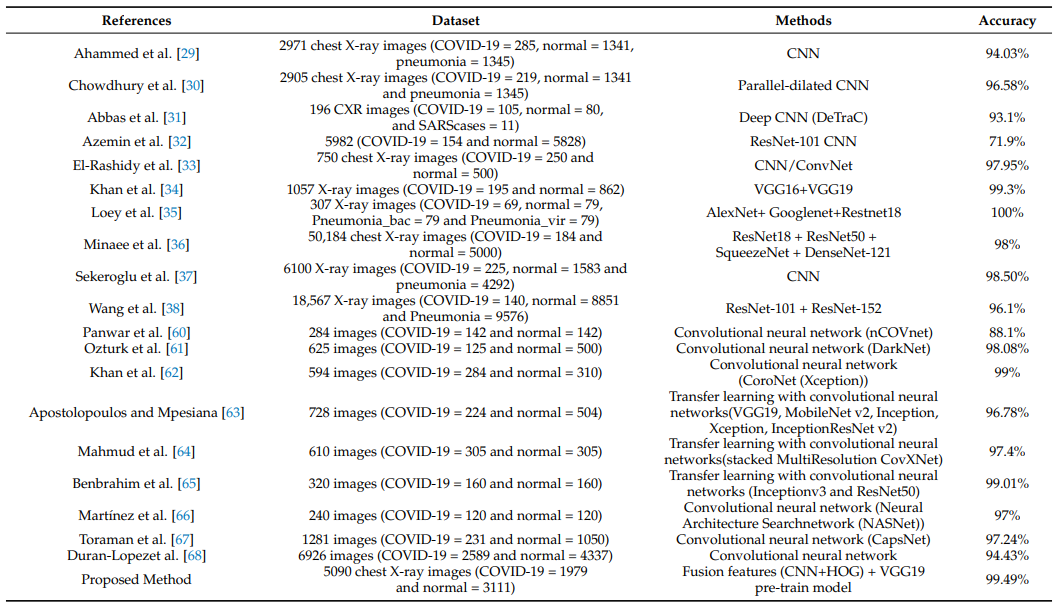

## ResNet 18
The first DNN we tested was ResNET Since it is a pre-trained model that reveals good results on a wide range of Computer Vision tasks. Instead of learning input features of image directly with a function H(x) (A stacking of multi-layer perceptron networks), the main idea of ResNet is to provide a residual function that can reframe H(x) = F(x)+x, where F(x) and x represent the stacked non-linear layers and the identity function (input=output) respectively.

This idea can solve the degradation problem of deep neuron networks (vanishing gradient) because it is easier to optimize the residual mapping function F(x) than the original one.

At this point we only used the network architecture and not the weights. We gained the weights by training the network on our data. Further down the road we will try to use the network including the weights and train the network on our data when the network will be locked to changes except the last layers.



In [ ]:
ResNet18 = models.resnet18(pretrained = True)
ResNet18.fc = torch.nn.Linear(in_features = 512, out_features = 2)
ResNet18 = ResNet18.to(device)
# checkpoint_ResNet18_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_ResNet18'

In [ ]:
ResNet18.load_state_dict(torch.load('/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_ResNet18/ckpt_19_05_-200.pk')) 

In [ ]:
ResNet18.load_state_dict(torch.load(checkpoint_ResNet18_path+'/ckpt-500.pk')) 

In order to train Resnet for our classification task, we used the following settings:

a.	We replaced the Fully connected layer with layer with n features output and 2 outputs.

b.	We used the Cross Entropy loss as a Criterion.

c.	We used SGD with momentum 0.7 as our Optimizer and learning rate decay starting from lr=0.001.


In [ ]:
ResNet18 = models.resnet18(pretrained = True)
ResNet18.fc = torch.nn.Linear(in_features = 512, out_features = 2)
ResNet18 = ResNet18.to(device)
criterion_ResNet18 = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ResNet18 = optim.SGD(ResNet18.parameters(), lr=0.001, momentum=0.7)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ResNet18, step_size=7, gamma=0.1)
num_epochs=20
checkpoint_ResNet18_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_ResNet18'
# ResNet18.load_state_dict(torch.load('/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/ckpt-500.pk'))
ResNet18,train_statistics,val_statistics = train_model(ResNet18, criterion_ResNet18,
                                                       optimizer_ResNet18, exp_lr_scheduler,
                                                       num_epochs,checkpoint_path=checkpoint_ResNet18_path+'/ckpt_19_05_-{}.pk')                    

In [ ]:
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(ResNet18,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}%'.format(F1_score))

In [ ]:
get_accuracy(ResNet18,test)

In [ ]:
plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])

### **ResNet18 - Conclusions**
1. After aproximatlly 10 epochs the model accuracy is steady.
2. test accuarcy : 97%
3. Trainable params: 11,177,538
 

In [ ]:
summary(ResNet18, (3, 224, 224))

##VGG16
VGG16 is a convolutional neural network model proposed in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. We decided to test this model due to his achievement of 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

At first, we suggested to test AlexNet for our task, but VGG16 has empirically prove to make improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another.

Vgg16 comprised of much less layers in comparison to ResNet18.

Once again, we only used the network architecture and not the weights. We gained the weights by training the network on our data. Further down the road we will try to use the network including the weights and train the network on our data when the network will be locked to changes except the last layers.


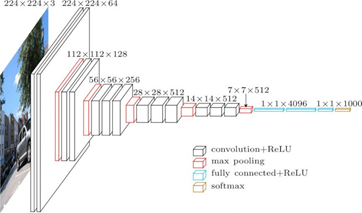

In [ ]:
vgg16.features[39] = torch.nn.Linear(in_features = 512, out_features = 2)

In order to train VGG16 for our classification task, we used the following settings:

a.	We replaced the Fully connected layer with layer with n features output and 2 outputs.

b.	We used the Cross Entropy loss as a Criterion.

c.	We used SGD with momentum 0.9 as our Optimizer and learning rate decay starting from lr=0.001.


In [ ]:
vgg16 = models.vgg16(pretrained = True)
vgg16.fc = torch.nn.Linear(in_features = 512, out_features = 2)
vgg16 = vgg16.to(device)
checkpoint_VGG16_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_VGG16'
summary(vgg16, (3, 224, 224))
vgg16.classifier

In [ ]:
vgg16 = models.vgg16(pretrained = True)
vgg16.fc = torch.nn.Linear(in_features = 512, out_features = 2)
vgg16 = vgg16.to(device)
criterion_vgg16 = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_vgg16 = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg16, step_size=7, gamma=0.1)
num_epochs=20
checkpoint_VGG16_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_VGG16'
vgg16,train_statistics,val_statistics = train_model(vgg16, criterion_vgg16,
                                                    optimizer_vgg16, exp_lr_scheduler,
                                                    num_epochs,checkpoint_path=checkpoint_VGG16_path+'/ckpt-{}.pk')          

In [ ]:
vgg16.load_state_dict(torch.load(checkpoint_VGG16_path+'/ckpt-9.pk_best_model_wts'))

In [ ]:
get_accuracy(vgg16,test)

In [ ]:
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(vgg16,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score))

test acurracy=99.35018050541517%

true positives=2037

false positives=7 

true negatives=715 

false negatives=11

Specificity=99.0304

Sensitivity=99.46289

Percision=99.6575

F1_score=0.9956011730205278

In [ ]:
plot_learning_curve(list(range(num_epochs))[1:], (train_statistics[0])[1:],list(range(num_epochs))[1:], (train_statistics[1])[1:], (val_statistics[1])[1:], (val_statistics[0])[1:])

### **VGG16 - Conclusion** 
1. After aproximatlly 10 epochs the model accuracy is steady.
2. test accuarcy : 98.95%
3. much less layers in compersion to ResNet18 
4. Trainable params: 138,357,544

In [ ]:
summary(vgg16, (3, 224, 224))

#Network

##### Network 1 Setup

In [ ]:
class CNN_1st_try(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1st_try, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(n_feature*2*2, 100)
        self.fc2 = nn.Linear(100, output_size)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = x.view(-1, self.n_feature*2*2)
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        return x

In [ ]:
CNN_1st_try_model=CNN_1st_try(3,256,2)
CNN_1st_try_model = CNN_1st_try_model.to(device)
summary(CNN_1st_try_model, (3, 224, 224))
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt-500.pk'))

##### CNN 1st try CNN 



In [ ]:
CNN_1st_try_model = CNN_1st_try(3,256,2)
CNN_1st_try_model = CNN_1st_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_1st_try_model = optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_1st_try_model, step_size=7, gamma=0.1)
num_epochs=20
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
#CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-100.pk'))
CNN_1st_try_model,train_statistics,val_statistics = train_model(CNN_1st_try_model, criterion_CNN, optimizer_CNN_1st_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-{}.pk')   

In [ ]:
plot_learning_curve(list(range(num_epochs))[1:], (train_statistics[0])[1:],list(range(num_epochs))[1:], (train_statistics[1])[1:], (val_statistics[1])[1:], (val_statistics[0])[1:])

In [ ]:
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_1st_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score))

In [ ]:
CNN_1st_try_model=CNN_1st_try(3,256,2)
CNN_1st_try_model = CNN_1st_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_1st_try_model = optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_1st_try_model, step_size=7, gamma=0.1)
num_epochs=20
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-7.pk'))
CNN_1st_try_model,train_statistics,val_statistics = train_model(CNN_1st_try_model, criterion_CNN, optimizer_CNN_1st_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-{}.pk')   

In [ ]:
CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-13.pk_best_model_wts'))
# /content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN/ckpt___-7.pk_best_model_wts

07/05/21 test

In [ ]:
CNN_1st_try_model=CNN_1st_try(3,256,2)
CNN_1st_try_model = CNN_1st_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_1st_try_model = optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_1st_try_model, step_size=7, gamma=0.1)
num_epochs=20
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-100.pk'))
CNN_1st_try_model,train_statistics,val_statistics = train_model(CNN_1st_try_model, criterion_CNN, optimizer_CNN_1st_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt_27.05.21_-{}.pk')   

In [ ]:
# after 7 epochs ()
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_1st_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score))

03/06/21

In [ ]:
CNN_1st_try_model=CNN_1st_try(3,256,2)
CNN_1st_try_model = CNN_1st_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_1st_try_model = optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_1st_try_model, step_size=7, gamma=0.1)
num_epochs=20
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-100.pk'))
CNN_1st_try_model,train_statistics,val_statistics = train_model(CNN_1st_try_model, criterion_CNN, optimizer_CNN_1st_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt_03.06.21_-{}.pk')   

In [ ]:
plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))

In [ ]:
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_1st_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score))

In order to prevent Overfitting we will try the following tricks:

1. play with the learning rate schedular
2. initialize the Net with pre-trained weights
3. add DropOut and Batch Normalization layers






##### CNN 2nd try (lr_scheduler - step size =12)

In [ ]:
# lr is decaying after 12 epochs and not 7
CNN_1st_try_model=CNN_1st_try(3,256,2)
CNN_1st_try_model = CNN_1st_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_1st_try_model = optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_1st_try_model, step_size=12, gamma=0.1) # change step size to 12
num_epochs=20
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt_03.06.21_-4.pk_best_model_wts'))
CNN_1st_try_model,train_statistics,val_statistics = train_model(CNN_1st_try_model, criterion_CNN, optimizer_CNN_1st_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt_03.06.21_-{}.pk')   

In [ ]:
plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))

In [ ]:
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_1st_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score))

In [ ]:
CNN_1st_try_model=CNN_1st_try(3,256,2)
CNN_1st_try_model = CNN_1st_try_model.to(device)
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt_03.06.21_-12.pk_best_model_wts'))

In [ ]:
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_1st_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score))

##### CNN 3rd try (lr_scheduler - step size =21)

In [ ]:
CNN_1st_try_model=CNN_1st_try(3,256,2)
CNN_1st_try_model = CNN_1st_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_1st_try_model = optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_1st_try_model, step_size=21, gamma=0.1) # change step size to 21
num_epochs=20
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt_03.06.21_-4.pk_best_model_wts'))
CNN_1st_try_model,train_statistics,val_statistics = train_model(CNN_1st_try_model, criterion_CNN, optimizer_CNN_1st_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt_04.06.21_-{}.pk')   

In [ ]:
plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))

In [ ]:
plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_1st_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score))

Better results are given by chaning step size to 12


Typically, dropout is applied after the non-linear activation function (a). However, when using rectified linear units (ReLUs), it might make sense to apply dropout before the non-linear activation (b) for reasons of computational efficiency depending on the particular code implementation.

(a): Fully connected, linear activation -> ReLU -> Dropout -> …
(b): Fully connected, linear activation -> Dropout -> ReLU -> …

e.g., say we have the following activations in our hidden layer: [-1, -2, -3, 4, 5, 6]. Tthe output of the ReLU function is the following:

[0, 0, 0, 4, 5, 6]

then, with dropout, we might get the following with a 50% drop proba:

[0*2, 0, 0*2, 0, 0*2, 0] = [0, 0, 0, 0, 10, 0]

Now, if we would pass the input to the ReLU first and then the dropout, we would get the exact same results:

[-1, -2, -3, 4, 5, 6] -> [-1*2, 0, -3*2, 0, 5*2, 0]

[-2, 0, -6, 0, 10, 0] -> [0, 0, 0, 0, 10, 0]

#### CNN_1st_try_dropbatch_add

##### CNN_1 - 4 try (Dropout+Batchnorm)
Best Results so far were given by set the learning rate decay every 12 epoch, lets try add some new Dropout and batchNorm layers


adding BatchNorm layers after the 2nd,4th,6th conv layer in the feture extractor and after the 1st fully connected layer in the classifier. in addition there are 2 Dropout layers - Dropout with probability 0.15 after the 6th conv layer and Dropout with probability 0.3 after the 1st fully connected layer in the classifier.


In [ ]:
class CNN_1st_try_dropbatch_add(nn.Module): ## BS =32 ,  optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1st_try_dropbatch_add, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv4 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv5 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv6 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature)
        self.fc1 = nn.Linear(n_feature*2*2, 100)
        self.BatchNorm2=nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, output_size)
        self.dropout1 = nn.Dropout(0.15)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x, verbose=False):
        ### Feature Extraction Block ###
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        x = self.ReLU(x)
        x = self.conv6(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.dropout1(x)
        x = x.view(-1, self.n_feature*2*2)
        ### Classifier Block ### 
        # Fully-Connected layer #1
        x = self.fc1(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.dropout2(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        return x

In [ ]:
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
summary(CNN_2nd_try_model, (3, 224, 224))

In [ ]:
plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

We can Observe that our model is demonstrating poor results for the Validation data which derive directly from the over generalization caused by the addition of the Dropout and Batch Norm layers. Those algorithms include by default regularization parameters meant to prevent overfitting. Sometimes, they prevent the algorithm from learning.
We will Reduce their values and the amount of layers used.





##### CNN_1 - 5 try (BatchNorm removing)

remove the batch norm layers, ank keep both the Dropout layers and 2 layers of BatchNorm - one at the end of the feture extractor and one in the begining of the classifier

In [ ]:
class CNN_1st_try_dropbatch_add(nn.Module): ## BS =32 ,  optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1st_try_dropbatch_add, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv4 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv5 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv6 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature)
        self.fc1 = nn.Linear(n_feature*2*2, 100)
        self.BatchNorm2=nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, output_size)
        self.dropout1 = nn.Dropout(0.15)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        x = self.ReLU(x)
        x = self.conv6(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.dropout1(x)
        x = x.view(-1, self.n_feature*2*2)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.dropout2(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        return x

In [ ]:
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
summary(CNN_2nd_try_model, (3, 224, 224))

In [ ]:
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.SGD(CNN_2nd_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 12 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=12, gamma=0.1)
num_epochs=20
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_05.06.21_-8.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-{}.pk')  

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

In [ ]:
plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

we can notice that even though we are less prone to overfitting, our test reduced to 91.26% and we can observe to increase in the false positive criterion which affect dramatically on the Specificity criterion. we can also notice that our curves are noisy (less smooth).

we will try to apply only 1 layer of Dropout between the Fc layers with higher probability =  0.5.

our motivation is to imitate state-of-art network such as AlexNet ang VGG which uses Dropout layers with probability in range 0.5-0.8; and only in the classifier architecture.

ref : [dropout-for-regularizing-deep-neural-networks](https://https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)


##### CNN_1 - 6 try (1 Dropout Layer) + step_size=12

In [ ]:
class CNN_1st_try_dropbatch_add(nn.Module): ## BS =32 ,  optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1st_try_dropbatch_add, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv4 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv5 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv6 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature)
        self.fc1 = nn.Linear(n_feature*2*2, 100)
        self.BatchNorm2=nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, output_size)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        x = self.ReLU(x)
        x = self.conv6(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        # x = self.dropout1(x)
        x = x.view(-1, self.n_feature*2*2)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.dropout2(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        return x

In [ ]:
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.SGD(CNN_2nd_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 12 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=12, gamma=0.1)
num_epochs=35
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_1do_layer-{}.pk')  

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

We can notice that assigning 1 Dropout layer with probability 0f 0.5 between the classifier fully connected layers is Significantly reducing the gap between the loss curves. the model isnt memorize the training set even after 35 epochs.
As a result, we claim 94.33% of teat accuracy, while we getting notable decrease in the false positive mesure will lead to increase of apporximatly 13% in the Specificity criterion = 89.05%

##### CNN_1 - 7 try (no lr decay)
we will try to increase the Specificity by removing the lr schedular.

In [ ]:
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.SGD(CNN_2nd_try_model.parameters(), lr=0.01,momentum=0.9)
# dosent Decay LR 
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=num_epochs+1, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_1do_layer_no_decay-{}.pk')  

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

We can notice that the loss and accuracy are very not stable which yiels acurves that suffers from Sharp fluctuations (could occur due to high learning rate which led the parameter to "jump" over local minima ).
hench we will try to reduce the larning rate by factor of 0.1 from the begining i.e. lr = 0.001

##### CNN_1 - 8 try no lr decay + lr =0.001


In [ ]:
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.SGD(CNN_2nd_try_model.parameters(), lr=0.001,momentum=0.9)
# dosent Decay LR 
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=num_epochs+1, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_1do_0.001lr-{}.pk')  

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

We can notice that our curves are still having wild fluctuations at the very first epochs. we can also notice that we are the reciving the best results so far in an a manner of accuracy, specificity and etc.
we are also much less prone to overfitting.

test acurracy=97.03971119133574%.
Specificity=94.04432132963989%
Sensitivity=98.095703125%
Percision=97.90448343079922%
F1_score=0.98

lets try to reduce more the lr to 0.0005

##### CNN_1 - 9 try no lr decay + lr =0.0005




In [ ]:
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.SGD(CNN_2nd_try_model.parameters(), lr=0.0005,momentum=0.9)
# dosent Decay LR 
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=num_epochs+1, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_07.06.21_1do_0.0005lr-{}.pk')  

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

in the scenarion Sharp fluctuations begining to apper from the 7 epoch and so on. again we are reciving great results.

lets try to eliminate the fluctuations by adding learning rate decay and batch size increasing

##### CNN_1 - 10 try step size=7 + lr =0.001 + batch size =50 (instead of 32)




In [ ]:
###### lr_scheduler - no lr decay + lr =0.001
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.SGD(CNN_2nd_try_model.parameters(), lr=0.001,momentum=0.9)
# dosent Decay LR 
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=7, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_07.06.21_1do_0.001lr12-{}.pk')  

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

In [ ]:
plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

now we recive wild fluctuations at the very first epochs and then our curves is smoother. we can also notice that we have decay in our resuls in comparison to not using lr decay.

lets try to reduce more the lr to 0.0005 and increase the the batch size (in order to reduce the noise)

##### CNN_1 - 11 try step size=7 + lr =0.0005 + batch size =50



In [ ]:
###### lr_scheduler - no lr decay + lr =0.0005
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.SGD(CNN_2nd_try_model.parameters(), lr=0.0005,momentum=0.9)
# dosent Decay LR 
num_epochs=30
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=7, gamma=0.2)
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_08.06.21_1do_0.0005lr12-{}.pk')  

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

From the results above we can observe much less fluctioations, high test accuracy ~96% and our model dosent prone to overfitting. 

##Intermediate- Result Analysis #1: 
So far, we have seen 11 training procedures, while for some we used different network Architectures, and for others we tuned different Hyperparameters.

The table below summarizes the 11 Networks while presenting their performance and differences compering to initial Network:


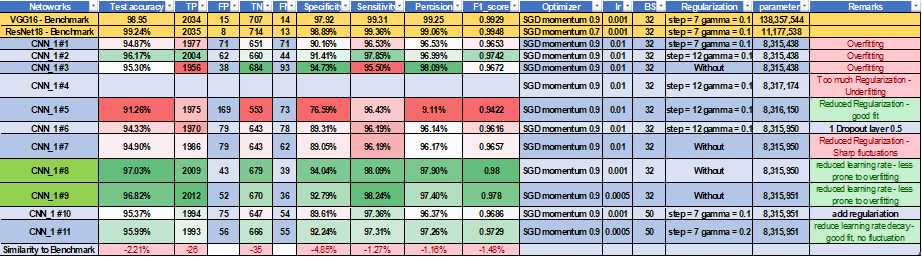

**Best performances given by the #8 and #9 models where the learning rate is equal to 0.001.**

#### **Adam optimizer**
we will test our model with differnet optimizer - Adam




Adam is a popular algorithm in the field of deep learning because it achieves good results fast.

Adam is combining the advantages of two other extensions of stochastic gradient descent, Specifically:

Adaptive Gradient Algorithm that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems) and Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

Empirical results demonstrate that Adam works well in practice and compares favorably to other stochastic optimization methods.

Adam was demonstrated empirically to show that convergence meets the expectations of the theoretical analysis. Adam was applied to the logistic regression algorithm on the MNIST digit recognition and IMDB sentiment analysis datasets, a Multilayer Perceptron algorithm on the MNIST dataset and Convolutional Neural Networks on the CIFAR-10 image recognition dataset. Using large models and datasets, Adam can efficiently solve practical deep learning problems.


##### CNN_1 - 12 try Adam + Weight decay + lr = 0.0001 

we will test our model with differnet optimizer - Adam

batch size=50

weight_decay=1e-9

lr= 0.0001

In [ ]:
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(), lr=0.0001,weight_decay=1e-9)
# optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(),lr=0.001,weight_decay=1e-6)
# dosent Decay LR 
num_epochs=30
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=12, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_07.06.21_1do_0.0005lr-10.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_08.06.21_1do_0.0005lr3rd-{}.pk')  

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

We recivied the best results so far: *test accuracy =98.08% and Specificity = 97.09%* !!!

although we recive small fluctioations are model isnt overfitting i.e. the gap betweeen the curves is steady.
just for comprasion:

**VGG16** : test accuracy 98.95% Specificity=97.92%

**ResNet**: test accuracy 99.28% Specificity=98.89%

**CNN_try_1** (1st model tried) : test acurracy 94.87% Specificity=90.16%

##### CNN_1 - 13 try Adam + Weight decay + lr = 0.0001 +no lr decay
lets try to not reduce the learning rate i.e. not use regularization based learning decay

In [ ]:
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(), lr=0.0001,weight_decay=1e-9)
# dosent Decay LR 
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=num_epochs+1, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weights'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_11.06.21_1do_adam-{}.pk')
# CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
#                         num_epochs,checkpoint_path=None)  

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

In [ ]:
CNN_2nd_try_model=CNN_1st_try_dropbatch_add(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_11.06.21_1do_adam-32.pk_best_model_wts'))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

we recived here similar results but the curves comprised  from more fluctuations

#### 3 FC layer classifier V1
now we will try to replace our classifer architecture by having 3 FC layers and 2 dropout layers, in a similar way to the state of the art networks such as VGG16 and AlexNet.

DropOut rate = 0.5 for both layers


In [ ]:
class CNN_2nd_try(nn.Module): ## BS =32 ,  optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_2nd_try, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv4 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv5 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv6 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature)
        self.fc1 = nn.Linear(n_feature*2*2, 512)
        self.fc3 = nn.Linear(512, 512)
        self.BatchNorm2=nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, output_size)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        x = self.ReLU(x)
        x = self.conv6(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        # x = self.dropout1(x)
        x = x.view(-1, self.n_feature*2*2)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        # x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.dropout2(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        return x

##### CNN_1 - 14 try Adam + Weight decay + lr = 0.0001
we will imitate the settings of the hyper parmeter we had for the Net that achives the best results so far.

In [ ]:
CNN_2nd_try_model=CNN_2nd_try(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(), lr=0.0001,weight_decay=1e-9)
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=12, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weights'
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_15.06.21_2do_adam-{}.pk')

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

In [ ]:
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

#### 3 FC layer classifier V2
we changed the Dropout rate to 0.75,0.85

In [ ]:
class CNN_2nd_try(nn.Module): ## BS =32 ,  optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_2nd_try, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv4 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv5 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv6 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature)
        self.fc1 = nn.Linear(n_feature*2*2, 512)
        self.fc3 = nn.Linear(512, 512)
        self.BatchNorm2=nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, output_size)
        self.dropout1 = nn.Dropout(0.8)
        self.dropout2 = nn.Dropout(0.75)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        x = self.ReLU(x)
        x = self.conv6(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        # x = self.dropout1(x)
        x = x.view(-1, self.n_feature*2*2)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        # x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.dropout2(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        # x = self.fc2(x)
        return x

##### Adam + lr = 0.001 + weight_decay + lr decay

In [ ]:
CNN_2nd_try_model=CNN_2nd_try(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(), lr=0.001,weight_decay=1e-9)
# optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(),lr=0.001,weight_decay=1e-6)
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=12, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weights'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_16.06.21_2do_adam-{}.pk')

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
Specificity=true_negatives/(true_negatives + false_positives)
Sensitivity=true_positives/(true_positives + false_negatives)
Percision=true_positives/(true_positives+false_positives)
F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
print('test acurracy={}%.'.format(acurracy*100))
print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

we can notice high learning rate

##### Adam + lr = 0.001 + weight_decay + no lr decay


In [ ]:
CNN_2nd_try_model=CNN_2nd_try(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(), lr=0.001,weight_decay=1e-9)
# optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(),lr=0.001,weight_decay=1e-6)
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=num_epochs+1, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_17.06.21_2do_adam-{}.pk')

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
confusion_matrix(true_positives, false_positives, true_negatives, false_negatives)

# Specificity=true_negatives/(true_negatives + false_positives)
# Sensitivity=true_positives/(true_positives + false_negatives)
# Percision=true_positives/(true_positives+false_positives)
# F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
# print('test acurracy={}%.'.format(acurracy*100))
# print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
# print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

Too high learning rate

##### Adam + lr = 0.0005 + weight_decay + no lr decay


In [ ]:
CNN_2nd_try_model=CNN_2nd_try(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(), lr=0.0005,weight_decay=1e-9)
# optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(),lr=0.001,weight_decay=1e-6)
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=12, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_17.06.21_2do_adam-{}.pk')

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
print('test accuracy :',acurracy)
confusion_matrix(true_positives, false_positives, true_negatives, false_negatives)

# Specificity=true_negatives/(true_negatives + false_positives)
# Sensitivity=true_positives/(true_positives + false_negatives)
# Percision=true_positives/(true_positives+false_positives)
# F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
# print('test acurracy={}%.'.format(acurracy*100))
# print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
# print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

In [ ]:
CNN_2nd_try_model=CNN_2nd_try(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_17.06.21_2do_adam-23.pk_best_model_wts'))
print('load succesfully')
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
print('test accuracy :',acurracy*100)
confusion_matrix(true_positives, false_positives, true_negatives, false_negatives)

##### CNN_1 - 15 Adam + lr = 0.0001 + weight_decay + lr decay


In [ ]:
CNN_2nd_try_model=CNN_2nd_try(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(), lr=0.0001,weight_decay=1e-9)
# optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(),lr=0.001,weight_decay=1e-6)
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=12, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_18.06.21_2do_adam-{}.pk')

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
print('test accuracy :',acurracy)
confusion_matrix(true_positives, false_positives, true_negatives, false_negatives)

# Specificity=true_negatives/(true_negatives + false_positives)
# Sensitivity=true_positives/(true_positives + false_negatives)
# Percision=true_positives/(true_positives+false_positives)
# F1_score=(2*Percision*Sensitivity)/(Percision+Sensitivity)
# print('test acurracy={}%.'.format(acurracy*100))
# print('true positives={}'.format(true_positives),' false positives={}'.format(false_positives), ' true negatives={}'.format(true_negatives),' false negatives={}'.format(false_negatives))
# print('Specificity={}%'.format(Specificity*100),' Sensitivity={}%'.format(Sensitivity*100),' Percision={}%'.format(Percision*100),'F1_score={}'.format(F1_score)) 

##### CNN_1 - 16 try Adam + lr = 0.00005 + weight_decay + no lr decay

In [ ]:
CNN_2nd_try_model=CNN_2nd_try(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(), lr=0.00005,weight_decay=1e-9)
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=num_epochs+1, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weights'
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_18.06.21_2do_adam-{}.pk')

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
print('test accuracy :',acurracy)
confusion_matrix(true_positives, false_positives, true_negatives, false_negatives)

##### CNN_1 - 17 try Adam + lr = 0.00005 + weight_decay + lr decay

In [ ]:
Run_Simulation(n_features=256,Arch=CNN_2nd_try,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",
lr_val=0.00005,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=35
            ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim= '/ckpt_24.06.21_2do_adam_0.00005-{}.pk')

In [ ]:
CNN_2nd_try_model=CNN_2nd_try(3,256,2)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(), lr=0.00005,weight_decay=1e-9)
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=12, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_24.06.21_2do_adam_0.00005-{}.pk')

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
print('test accuracy :',acurracy*100,'%')
confusion_matrix(true_positives, false_positives, true_negatives, false_negatives)

##Intermediate- Result Analysis #2: 
So far, we have seen 17 training procedures, while for some we used different network Architectures, and for others we tuned different Hyperparameters. The following table summarizes those Networks while presenting their performance and differences compering to initial Network:

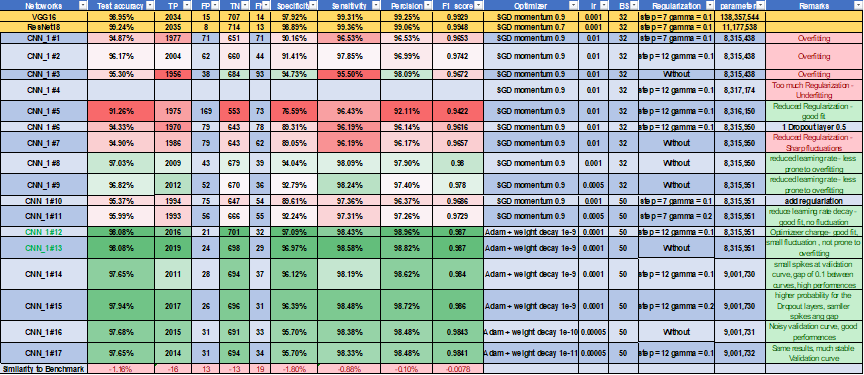

Best performances given by the #12 and #13 models, as described below.

**We are getting performances that are almost achieved the state-of-the-art performances as we can see at the Similarity to Benchmark line.**


##Insights:
**Test Accuracy**

We can observe That the cost **Significant Actions** taken which raises the accuracy of the model were to **reduce the learning** rate and use the **Adam optimizer**. From the other graph presented below, it is shown the all the tested aspects of performances were improved by those same actions taken. The Noticeable reduction on the learning rate Since the #8 Simulation yield much better accuracy, along with the regularization terms added and the Integration of the Adam optimizer with weight decay.

Hence, the obtained results are highly accurate and approaches the state-of-the-art accuracy by differing only 1.16% from ResNet18 – Which is acquired from more than 17 times larger number of parameters comparing to the proposed Network.  


**Ability to deal with COVID-19 Samples**

One of the main issues in our task is the deal with unbalanced data. in the First stage as presented here, we deal with data set that comprised from 2 Classes – "**Normal**" data which is 3 times greater than the "**COVID-19**" data.
Applying inappropriate evaluation metrics for model generated using imbalanced data Can be not represent anything about the model performances. Hence, we will use different evaluation metrices which will point out the performances for both the majority and the minority class. Those metrices will be computed based on the terms defines in the Metrics Section i.e. 

**True Positive**("Normal" Sample that predicted as "Normal"), **False Positive** ("COVID-19" Sample that predicted as "Normal"),
**True Negative**("COVID-19" Sample that predicted as "COVID-19") and **False Negative** ("Normal" Sample that predicted as "COVID-19")

Since the amount of "Normal" samples is 3 times larger than the "COVID-19" Samples we assuming that it is much harder for our model detecting "COVID-19" samples as "COVID-19" labels than detecting "Normal" samples as "Normal" labels. The Phenomena is due to the reason that the inference function of the Network in more influenced during the training procedure from the majority Samples i.e. "Normal" samples and less from the minority samples i.e. "COVID-19" Samples.

From that same reason it is more likely that our model will predict "COVID-19" as "Normal" than "Normal" as "COVID-19".

According to the clamming's above, the most pointing out Evaluation Metrics are:

a.	**Specificity** which measures the proportion of patients with COVID-19 that are correctly identified as having the condition.

b.	**Precision** which measures the proportion between patients that correctly identified as "Normal" and all other patients that identified as "Normal".


From the Results of the Simulated models we can notice that:

1.	the 1st and 2nd models which had high learning rate (0.01) and were highly prone to Overfitting achieves relatively low specificity and precision results.

2.	In the 5th model, we added Regularization to our model in the form of we Dropout and Batch Norm layers, with low probability, which caused to dramatically poor results in specificity and precision results. Hench, the ability of the model to detect "COVID19" Sample that predicted as "COVID19" is Significantly impaired

3.	Using the Adam Optimizer and reducing the learning rate caused to our model to be much less prone to overfitting and as a result the inference function is trained better to detect both the majority and the minority samples.


**F1 Score**
As we describe earlier, F1 Score is the most representative measure in our task, since we dealing with uneven class distribution (large number of Actual Negatives). As mentioned above, We can observe That the **reduction of the learning rate** and use the **Adam optimizer** improve d the model Significantly, as those models achieves the higher F1-scores in comparison to the other tested models.


###Higher number of Features Architecture
The Next element we will put into test is the effect of the number of features i.e. the number of filters used in every convolutional layer on the model performances.

Abstractedly, those filters in each conv layer are used to capture patterns. For example, the first layer of filters captures patterns like edges, corners, dots etc. Subsequent layers combine those patterns to make bigger patterns (like combining edges to make squares, circles, etc.).

as we move forward in the layers, the patterns get more complex like cage bones of lungs. hence there are larger combinations of patterns to capture. That is reason we would like to increase the number of filters so that in subsequent layers we will be able to capture as many combinations as possible. Of course, it comes as trade off with the model running time and complexity.


##### 3 FC layer classifier ver  3
we will try to simulateour model with differnet number of fetures

##### CNN_1 - 18 try Adam + lr = 0.0001 + weight_decay + lr decay + 2DO layers + 300 fetures

In [ ]:
Run_Simulation(n_features=300,Arch=CNN_2nd_try,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=35
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_24.06.21_2do_adam-{}_350_2try.pk')

In [ ]:
CNN_Aadm_2try_model=CNN_2nd_try(3,300,2) #BS=50
CNN_Aadm_2try_model = CNN_Aadm_2try_model.to(device)
CNN_Aadm_2try_model.load_state_dict(torch.load('/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN/ckpt_24.06.21_2do_adam-25_350_2try.pk_best_model_wts'))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_Aadm_2try_model,test)
print('test accuracy :',acurracy)
confusion_matrix(true_positives, false_positives, true_negatives, false_negatives)

##### CNN_1 - 19 try Adam + lr = 0.0001 + weight_decay + lr decay step size 12 + 2DO layers + 128 features

In [ ]:
Run_Simulation(n_features=128,Arch=CNN_2nd_try,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_26.06.21_2do_adam-{}_128_0.0001_try1.pk')

##### CNN_1 - 20 try Adam + lr = 0.0001 + weight_decay +step size= 7 + 2DO layers + 128 features

In [ ]:
Run_Simulation(n_features=128,Arch=CNN_2nd_try,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=7,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_26.06.21_2do_adam-{}_128_0.0001_try2.pk')

In [ ]:
CNN_Aadm_2try_model=CNN_2nd_try(3,128,2) #BS=50
CNN_Aadm_2try_model = CNN_Aadm_2try_model.to(device)
CNN_Aadm_2try_model.load_state_dict(torch.load('/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN/ckpt_26.06.21_2do_adam-20_128_0.0001_try2.pk_best_model_wts'))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_Aadm_2try_model,test)
print('test accuracy :',acurracy)
confusion_matrix(true_positives, false_positives, true_negatives, false_negatives)

In [ ]:
class CNN_1st_try_dropbatch_add(nn.Module): ## BS =32 ,  optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1st_try_dropbatch_add, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv4 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv5 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv6 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature)
        self.fc1 = nn.Linear(n_feature*2*2, 100)
        self.BatchNorm2=nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, output_size)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        x = self.ReLU(x)
        x = self.conv6(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        # x = self.dropout1(x)
        x = x.view(-1, self.n_feature*2*2)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.dropout2(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        return x

##### CNN_1 - 21 try Adam + lr = 0.0001 + weight_decay + lr decay step size 12 + 1DO layer + 300 features

In [ ]:
Run_Simulation(n_features=300,Arch=CNN_1st_try_dropbatch_add,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=35
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_25.06.21_1do_adam-{}_350.pk')

In [ ]:
CNN_Aadm_2try_model=CNN_1st_try_dropbatch_add(3,300,2) #BS=50
CNN_Aadm_2try_model = CNN_Aadm_2try_model.to(device)
CNN_Aadm_2try_model.load_state_dict(torch.load('/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN/ckpt_25.06.21_1do_adam-28_350.pk_best_model_wts'))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_Aadm_2try_model,test)
print('test accuracy :',acurracy)
confusion_matrix(true_positives, false_positives, true_negatives, false_negatives)
# /content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN/ckpt_25.06.21_1do_adam-28_350.pk_best_model_wts

##### CNN_1 - 22 try Adam + lr = 0.0001 + weight_decay + lr decay step size 12 + 1DO layer + 350 features + BS 32

In [ ]:
# Bs reduced to 32 in order to have the ability to run
Run_Simulation(n_features=350,Arch=CNN_1st_try_dropbatch_add,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_25.06.21_1do_adam-{}_320_Real.pk')

##### Adam + lr = 0.00005 + weight_decay + lr decay step size 12 + 1DO layer + 128 features + BS 50

In [ ]:
Run_Simulation(n_features=128,Arch=CNN_1st_try_dropbatch_add,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.00005
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_26.06.21_1do_adam-{}_350.pk')

##### CNN_1 - 23 try Adam + lr = 0.0001 + weight_decay + lr decay step size 12 + 1DO layer + 128 features

In [ ]:
Run_Simulation(n_features=128,Arch=CNN_1st_try_dropbatch_add,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_26.06.21_1do_adam-{}_128_0.0001_try2.pk')

In [ ]:
Run_Simulation(n_features=384,Arch=CNN_1st_try_dropbatch_add,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_26.06.21_1do_adam-{}_384_0.0001_try2.pk')

In [ ]:
plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))

In [ ]:
CNN_2nd_try_model=CNN_2nd_try(3,512,2) #BS=32
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(), lr=0.0001,weight_decay=1e-9)
# optimizer_CNN_2nd_try_model = optim.Adam(CNN_2nd_try_model.parameters(),lr=0.001,weight_decay=1e-6)
num_epochs=35
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_2nd_try_model, step_size=12, gamma=0.1)
checkpoint_optimizer_CNN_2nd_try_model_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weights'
# CNN_2nd_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_06.06.21_-6.pk_best_model_wts'))
CNN_2nd_try_model,train_statistics,val_statistics = train_model(CNN_2nd_try_model, criterion_CNN, optimizer_CNN_2nd_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_2nd_try_model_path+'/ckpt_23.06.21_2do_adam_500-{}.pk')

plot_learning_curve(list(range(num_epochs)), (train_statistics[0]),list(range(num_epochs)), (train_statistics[1]), (val_statistics[1]), (val_statistics[0]))
acurracy,true_positives, false_positives, true_negatives, false_negatives=get_accuracy_with_confusion(CNN_2nd_try_model,test)
print('test accuracy :',acurracy)
confusion_matrix(true_positives, false_positives, true_negatives, false_negatives)

#### ConvNet - Simulations

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, input_size, n_feature, output_size):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(input_size, n_feature, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(n_feature, n_feature*2, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer3 = nn.Sequential(
        nn.Conv2d(n_feature*2, n_feature*4, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer4 = nn.Sequential(
        nn.Conv2d(n_feature*4, n_feature*8, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(14 * 14 * n_feature*8, 1000)
    self.fc2 = nn.Linear(1000, output_size)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = out.reshape(out.size(0), -1)
    # print(out.shape)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, input_size, n_feature, output_size):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(input_size, n_feature, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(n_feature, n_feature*2, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer3 = nn.Sequential(
        nn.Conv2d(n_feature*2, n_feature*4, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer4 = nn.Sequential(
        nn.Conv2d(n_feature*4, n_feature*8, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(14 * 14 * n_feature*8, 1000)
    self.fc2 = nn.Linear(1000, output_size)
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = out.reshape(out.size(0), -1)
    # print(out.shape)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [ ]:
CNN_3nd_try_model=ConvNet(3,128,2) #BS=32
CNN_3nd_try_model = CNN_3nd_try_model.to(device)
summary(CNN_3nd_try_model, (3, 224, 224))

In [ ]:
Run_Simulation(n_features=8,Arch=ConvNet,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_26.06.21_ConvNet-{}_32_0.0001_.pk')

In [ ]:
Run_Simulation(n_features=32,Arch=ConvNet,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_26.06.21_ConvNet-{}_32_0.0001_.pk')

In [ ]:
Run_Simulation(n_features=64,Arch=ConvNet,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_26.06.21_ConvNet-{}_32_0.0001_.pk')

In [ ]:
Run_Simulation(n_features=128,Arch=ConvNet,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_26.06.21_ConvNet-{}_32_0.0001_.pk')

In [ ]:
Run_Simulation(n_features=128,Arch=ConvNet,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.00005
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weights'
               ,checkpoint_of_sim='/ckpt_27.06.21_ConvNet-{}_128_0.00005_.pk')

In [ ]:
Run_Simulation(n_features=128,Arch=ConvNet,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=31,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_27.06.21_ConvNet-{}_128_0.0001_no_reg_.pk')

In [ ]:
Run_Simulation(n_features=128,Arch=ConvNet,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=7,gamma_val=0.1,num_epochs=30
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_27.06.21_ConvNet-{}_128_0.0001_step=7_.pk')

#### CNN_4 - 2DO model with ascending number of features

In the Second stage, we will gradually ascend the number of filters in each convolutional layer.

Our Rationale here is that the higher the number of filters in each layer is, the higher the number of abstractions that our Network is able to extract from image data. The reason why the number of filters is generally ascending is that at the input layer the Network receives raw pixel data that are always noisy. Due to that we let the convolutional layers to extract at the beginning some relevant information from noisy, "dirty" raw pixel data. Once the useful features have been extracted, then we make the CNN elaborate more complex abstractions on it – by taking higher number of filters. That is why we would like that the number of filters increase as the Network gets deeper.

We will try to evaluate the ascending in both leading Architectures as presented above while taking in account that in the ascending Network we probably reach enormous number of trainable parameters.


In [ ]:
# builf from CNN_2
class CNN_4th_try(nn.Module): ## BS =32 ,  optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_4th_try, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=n_feature, kernel_size=5,stride=1, padding=2)
        self.conv2 = nn.Conv2d(n_feature, n_feature*2, kernel_size=5,stride=1, padding=2)
        self.conv3 = nn.Conv2d(n_feature*2, n_feature*4, kernel_size=5,stride=1, padding=2)
        self.conv4 = nn.Conv2d(n_feature*4, n_feature*8, kernel_size=5,stride=1, padding=2)
        self.conv5 = nn.Conv2d(n_feature*8, n_feature*16, kernel_size=5,stride=1, padding=2)
        # self.conv6 = nn.Conv2d(n_feature*8, n_feature*16, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature*16)
        self.fc1 = nn.Linear(n_feature*16*14*14, 1000)
        # self.fc3 = nn.Linear(1000, 100)
        self.BatchNorm2=nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, output_size)
        self.dropout1 = nn.Dropout(0.8)
        self.dropout2 = nn.Dropout(0.75)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = x.view(-1,self.n_feature*16*14*14)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.dropout1(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        return x

In [ ]:
CNN_3nd_try_model=CNN_4th_try(3,64,2) #BS=32
CNN_3nd_try_model = CNN_3nd_try_model.to(device)
summary(CNN_3nd_try_model, (3, 224, 224))

##### CNN_1 - 24 try Adam + lr = 0.0001 + Weight decay + lr deacy + CNN2 + **ascending** 64 features

In [ ]:
Run_Simulation(n_features=64,Arch=CNN_4th_try,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=25
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_28.06.21_CNN_4th_try-{}_64_0.0001_.pk')

##### Adam + lr = 0.0001 + Weight decay + lr deacy 12 + CNN2 + 32 features + **ascending**

In [ ]:
CNN_3nd_try_model=CNN_4th_try(3,32,2) #BS=32
CNN_3nd_try_model = CNN_3nd_try_model.to(device)
summary(CNN_3nd_try_model, (3, 224, 224))

In [ ]:
Run_Simulation(n_features=32,Arch=CNN_4th_try,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=25
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_28.06.21_CNN_4th_try-{}_32_0.0001_.pk')

In [ ]:
CNN_3nd_try_model=CNN_4th_try(3,16,2) #BS=32
CNN_3nd_try_model = CNN_3nd_try_model.to(device)
summary(CNN_3nd_try_model, (3, 224, 224))

In [ ]:
Run_Simulation(n_features=8,Arch=CNN_4th_try,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=25
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_02.07.21_CNN_4th_try-{}_8_0.0001_.pk')

#### CNN_1st_try_ascending

In [ ]:
class CNN_1st_try_ascending(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1st_try_ascending, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=n_feature, kernel_size=5,stride=1, padding=2)
        self.conv2 = nn.Conv2d(n_feature, n_feature*2, kernel_size=5,stride=1, padding=2)
        self.conv3 = nn.Conv2d(n_feature*2, n_feature*4, kernel_size=5,stride=1, padding=2)
        self.conv4 = nn.Conv2d(n_feature*4, n_feature*8, kernel_size=5,stride=1, padding=2)
        self.conv5 = nn.Conv2d(n_feature*8, n_feature*16, kernel_size=5,stride=1, padding=2)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2,stride=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature*16)
        self.fc1 = nn.Linear(n_feature*16*14*14, 1000)
        self.BatchNorm2=nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, output_size)

        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature*16)
        self.fc1 = nn.Linear(n_feature*16*14*14, 100)
        # self.fc3 = nn.Linear(1000, 100)
        self.BatchNorm2=nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, output_size)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        # x = self.ReLU(x)
        # x = self.conv6(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        # x = self.dropout1(x)
        x = x.view(-1, self.n_feature*16*14*14)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.dropout2(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        return x

In [ ]:
CNN_3nd_try_model=CNN_1st_try_ascending(3,128,2) #BS=32
CNN_3nd_try_model = CNN_3nd_try_model.to(device)
summary(CNN_3nd_try_model, (3, 224, 224))

##### CNN_1 - 26 try Adam + lr = 0.0001 + Weight decay + lr deacy 12 + CNN1 + 128 features + **ascending**

In [ ]:
Run_Simulation(n_features=128,Arch=CNN_1st_try_ascending,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=25
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_28.06.21_CNN_1st_try_ascending-{}_128_0.0001_.pk')

##### CNN_1 - 27 try Adam + lr = 0.0001 + Weight decay + lr deacy 12 + CNN1 + 64 features + **ascending**

In [ ]:
Run_Simulation(n_features=64,Arch=CNN_1st_try_ascending,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=25
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_29.06.21_CNN_1st_try_ascending-{}_64_0.0001_.pk')

In [ ]:
model_64=CNN_1st_try_ascending(3,64,2) #BS=32
model_64 = model_64.to(device)
summary(model_64, (3, 224, 224))

##### CNN_1 - 28 try Adam + lr = 0.0001 + Weight decay + lr deacy 12 + CNN1 + 32 features + **ascending**

In [ ]:
Run_Simulation(n_features=32,Arch=CNN_1st_try_ascending,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=25
               ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weights'
               ,checkpoint_of_sim='/ckpt_30.06.21_CNN_1st_try_ascending-{}_32_0.0001_.pk')

In [ ]:
model_32=CNN_1st_try_ascending(3,32,2) #BS=32
model_32 = model_32.to(device)
summary(model_32, (3, 224, 224))

##### CNN_1 - 29 try Adam + lr = 0.0001 + Weight decay + lr deacy 12 + CNN1 + 16 features + **ascending**

In [ ]:
Run_Simulation(n_features=16,Arch=CNN_1st_try_ascending,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=25
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_30.06.21_CNN_1st_try_ascending-{}_16_0.0001_.pk')

In [ ]:
model_16=CNN_1st_try_ascending(3,16,2) #BS=32
model_16 = model_16.to(device)
summary(model_16, (3, 224, 224))

In [ ]:
Run_Simulation(n_features=8,Arch=CNN_1st_try_ascending,output_size=2,criterion="CrossEntropy",optimizer_name="Adam",lr_val=0.0001
               ,weight_decay_val=1e-9,step_size_val=12,gamma_val=0.1,num_epochs=25
               ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
               ,checkpoint_of_sim='/ckpt_30.06.21_CNN_1st_try_ascending-{}_8_0.0001_.pk')

#1st Stage Result Analysis
So far, we have seen 27 training procedures, while the latest and the most productive models presented were differ by their number of filters in the convolutional layers, of alternatively different by the ascending structure of the convolutional layers in their architecture.

The following table summarizes those Networks while presenting their performance and differences compering to initial Network:


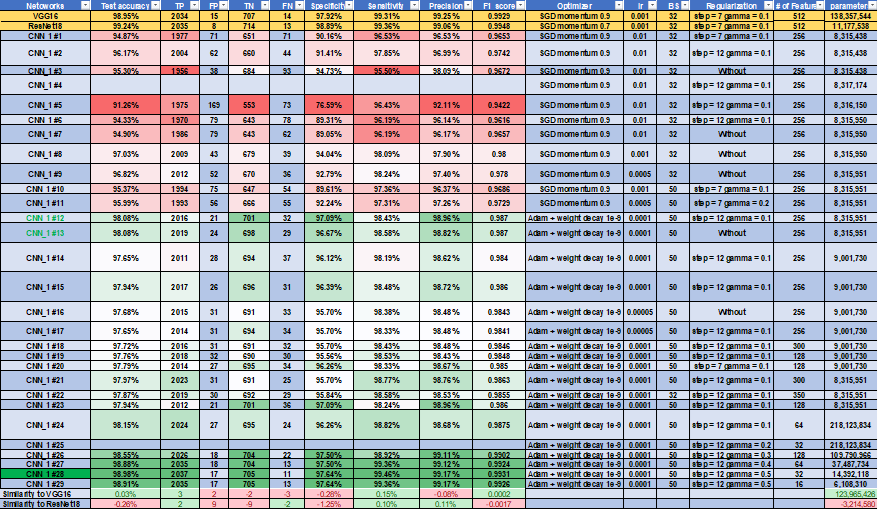

Best performances given by the #12 and #13 models, as described below.

**We are getting performances that are almost achieved the state-of-the-art performances as we can see at the Similarity to Benchmark line.**


##Insights
1.	**Test Accuracy and Specificity**

We can observe That the most **Significant Actions** taken which raises the accuracy of the model were to **reduce the learning rate** , use the **Adam optimizer** and to integrate **ascending number of filters** in the convolutional layers – which is the tie break action that put our model In the front line with the state-of-the-are tested models.

In addition, several regularization techniques were used in order to improve the model by preventing the overfitting phenomena: **Early Stoppings**, Regularization Using **Dropout** and **Batch Normalization** layers, Apply Regularization term which boils down to adding a cost to the loss function – **weight decay**, **learning rate decay**, Reduction of **Network Capacity** and etc.
Those actions and techniques help to improve the model by preventing the overfitting and as a result the learning process becomes more efficient, and it also allows it to converge faster.
We can also observe that by gradually ascending the number of filters in each convolutional layer our Network is able to extract complex abstractions from the data which generate more accurate and precise model, even though we are dealing with unbalanced data. We can notice that our model reaches:
1.	 higher **Accuracy** than VGG16 which comprised from 123 million more parameters than our model.

2.	Higher **Sensitivity** than both ResNet and VGG16 which mean our model is perform better in identifying "Normal" patients as "Normal" than the Benchmarks.

3.	Higher **Precision** than ResNet18 which mean that our model has better ability to Classify "Normal" as "Normal" proportional to all samples that classified as " Normal"

4.	Higher **F1-Score** than VGG16 which mean we have more balance between Precision and Recall. 

F1 Score might be a better measure to use seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives) – as in our problems.



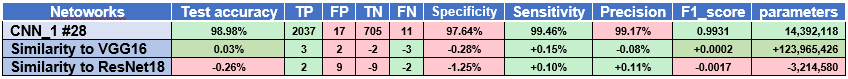